In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/home/iain/Desktop/IEL')
from DataGeneratorPredictors import calculateWaterAndLevelDifference

# IEL DATA EXPLORATION - Daily Data

In [2]:
# Import the new data and create a dataframe
rain = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Precipitation.csv', delimiter=';')
rain.rename(columns={'Value': 'Precipitation'}, inplace=True)
flow = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Mean Flow Rate.csv', delimiter=';')
flow.rename(columns={'Value': 'Flow Rate'}, inplace=True)
level = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Daily Aggregates/Daily Mean Level.csv', delimiter=';')
level.rename(columns={'Value': 'Water Level'}, inplace=True)

# Merge the 3 datasets into one
merged = pd.merge(rain, flow, on=['#Timestamp'])
merged = pd.merge(merged, level, on=['#Timestamp'])
merged = merged.drop('Quality Code_x', axis=1)
merged = merged.drop('Quality Code_y', axis=1)
merged = merged.drop('Quality Code', axis=1)
merged.dropna(inplace=True)

merged = calculateWaterAndLevelDifference(merged, daily=True)
merged.describe()

,Precipitation,Flow Rate,Water Level,Water Difference,Level Difference
count,9388.000000,9388.000000,9388.000000,9.388000e+03,9388.000000
mean,5.075852,2.571336,0.461204,-5.399188e+03,-0.000023
std,15.217056,3.502277,0.209103,6.209326e+05,0.170803
min,0.000000,0.000000,0.175000,-2.889491e+06,-1.685000
25%,0.000000,0.504000,0.306000,-1.044581e+05,-0.052000
50%,1.200000,1.251500,0.404000,-3.205440e+04,-0.010000
75%,6.800000,3.147500,0.561000,5.451435e+04,0.028000
max,949.600000,58.651000,2.532000,3.981187e+07,2.111000


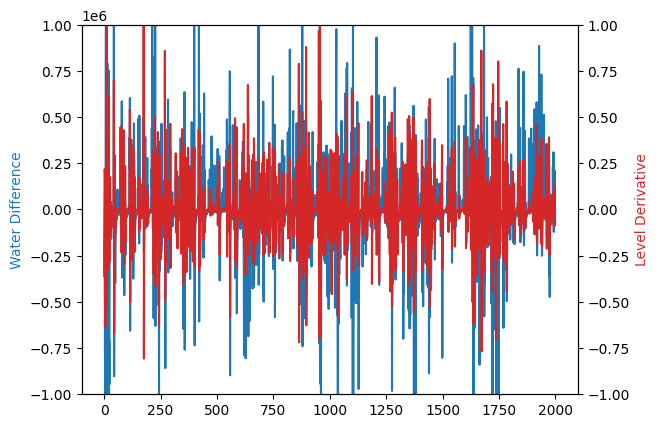

In [3]:
# Plot the water difference and the level derivative against the date with different axis scales
fig, ax1 = plt.subplots()
ax1.plot(merged['Water Difference'].iloc[0:2000])
ax1.set_ylabel('Water Difference', color='tab:blue')
ax1.set_ylim(-1000000, 1000000)
ax2 = ax1.twinx()
ax2.plot(merged['Level Difference'].iloc[0:2000], color='tab:red')
ax2.set_ylabel('Level Derivative', color='tab:red')
ax2.set_ylim(-1, 1)
plt.show()

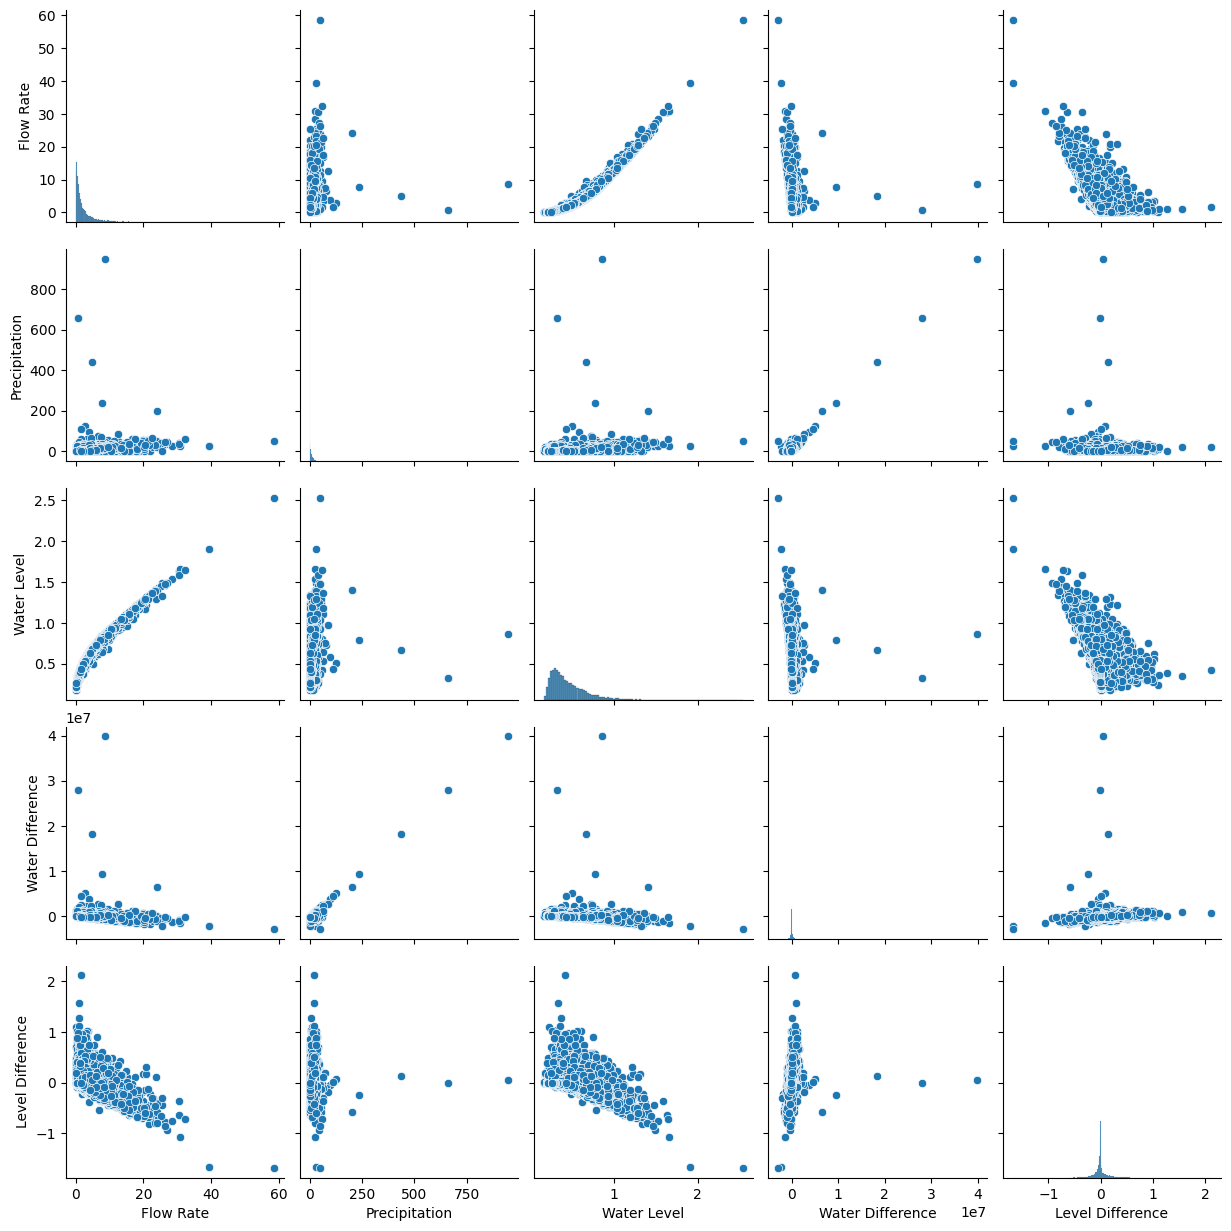

In [4]:
cols = ['Flow Rate', 'Precipitation', 'Water Level', 'Water Difference', 'Level Difference']
sns.pairplot(merged[cols], height=2.5)

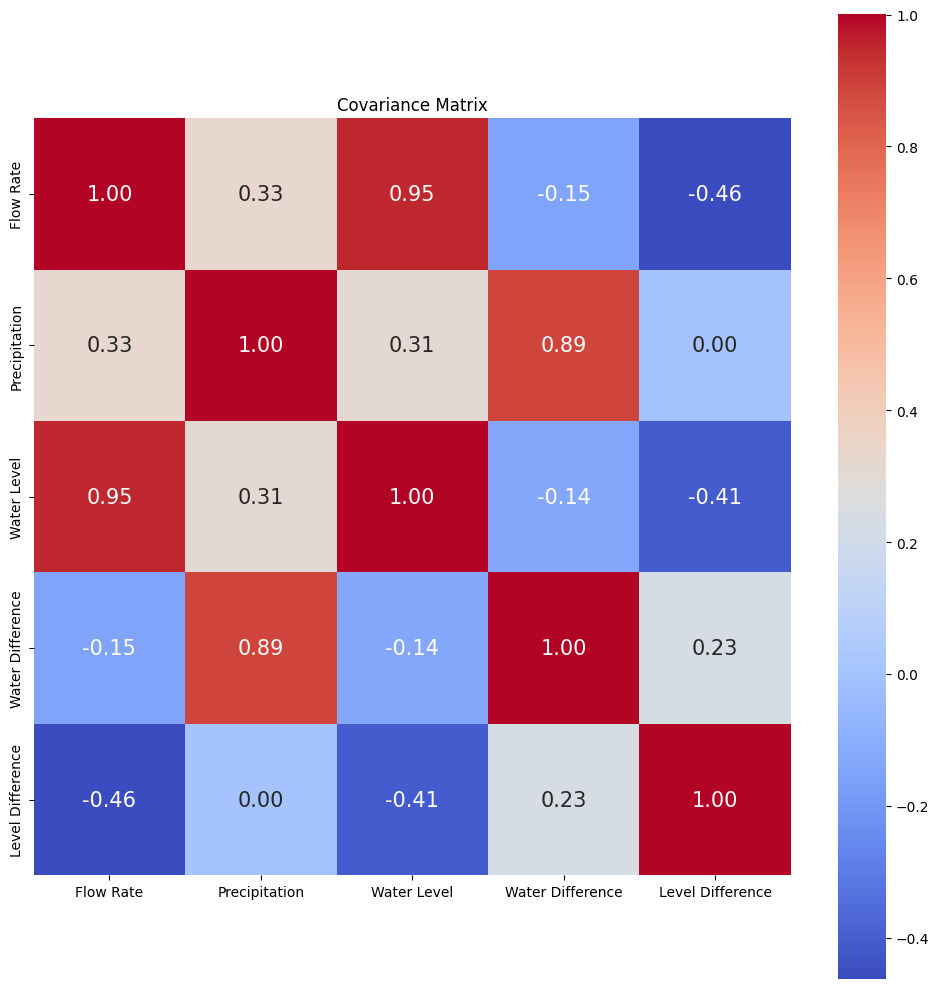

In [5]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(merged[cols].values)
cov_mat = np.cov(X_std.T)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm', yticklabels=cols, xticklabels=cols)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

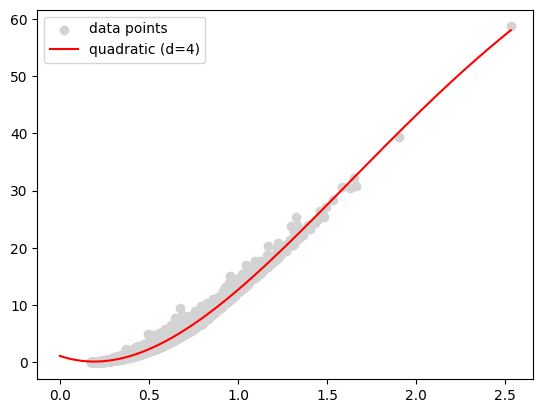

In [6]:
# Fit a polynomial curve to the data
X = merged['Water Level'].values.reshape(-1, 1)
y = merged['Flow Rate'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=4)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='o')

x = np.linspace(0, max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='quadratic (d=4)', color='red')

plt.legend(loc='upper left')
plt.show()

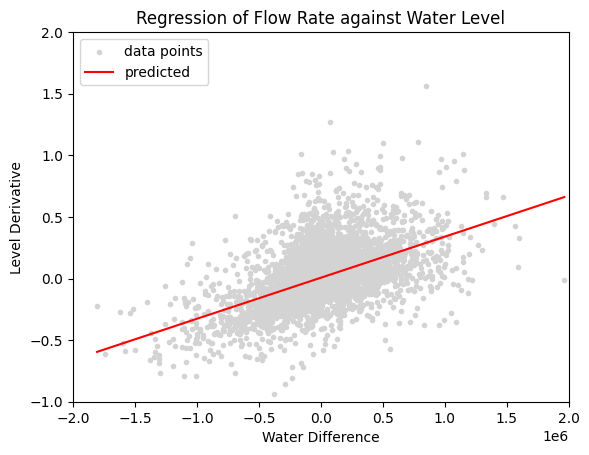

In [7]:
# Remove days with water difference > 2000000 and > 2000000
typical = merged[merged['Water Difference'] < 2000000]
typical = typical[typical['Water Difference'] > -2000000]

# Fit a polynomial curve of Water difference (independent) and level derivative (dependent)
X = typical['Water Difference'].values.reshape(-1, 1)
y = typical['Level Difference'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=1)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='.')

x = np.linspace(min(X), max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='predicted', color='red')

plt.xlim(-2000000, 2000000)
plt.ylim(-1, 2)

plt.legend(loc='upper left')
plt.title('Regression of Flow Rate against Water Level')
plt.xlabel('Water Difference')
plt.ylabel('Level Derivative')
plt.show()

# IEL DATA EXPLORATION - 15 Minute Data

In [8]:
# Import the data
rain = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Precipitation.csv', delimiter=';')
rain.rename(columns={'Value': 'Precipitation'}, inplace=True)
flow = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Flow Rate.csv', delimiter=';')
flow.rename(columns={'Value': 'Flow Rate'}, inplace=True)
level = pd.read_csv('/home/iain/Desktop/IEL/Data/Real Data/Quater_Hourly_Readings/Quarter Hourly Level.csv', delimiter=';')
level.rename(columns={'Value': 'Water Level'}, inplace=True)

# Merge the data
merged = pd.merge(rain, flow, on='#Timestamp')
merged = pd.merge(merged, level, on='#Timestamp')
merged = merged.drop('Quality Code', axis=1)
merged = merged.drop('Quality Code_x', axis=1)
merged = merged.drop('Quality Code_y', axis=1)
merged.dropna(inplace=True)

# Calculate the difference between the water coming in and the water going out and calculate the water level difference.
merged = calculateWaterAndLevelDifference(merged, daily=False)

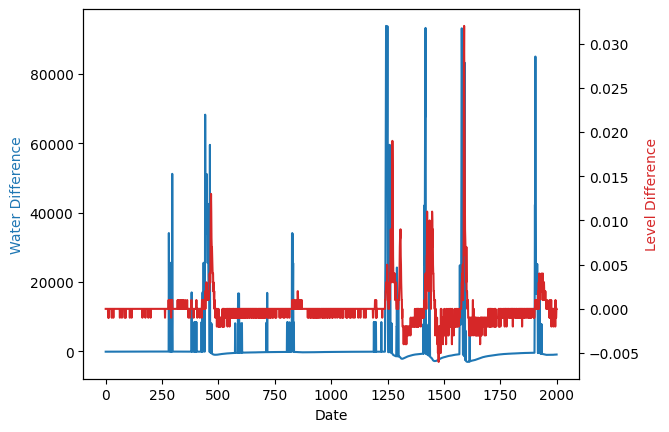

In [9]:
# Plot the water difference and the level derivative against the date with different axis scales
fig, ax1 = plt.subplots()
ax1.plot(merged['Water Difference'].iloc[0:2000])
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Difference', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(merged['Level Difference'].iloc[0:2000], color='tab:red')
ax2.set_ylabel('Level Difference', color='tab:red')
plt.show()

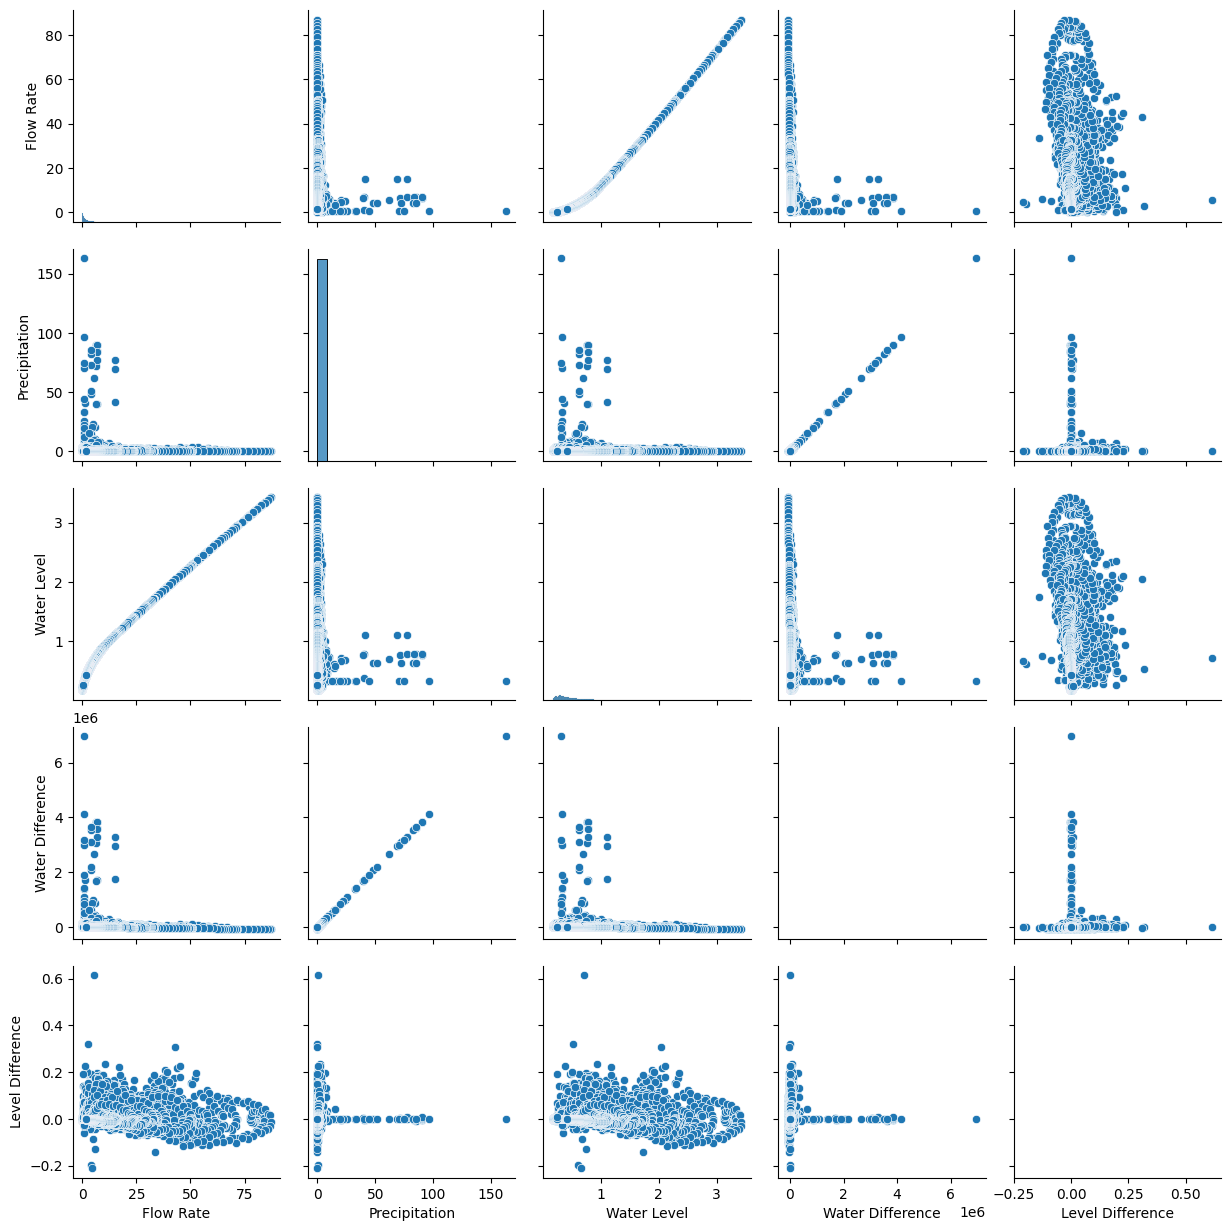

In [10]:
cols = ['Flow Rate', 'Precipitation', 'Water Level', 'Water Difference', 'Level Difference']
sns.pairplot(merged[cols], height=2.5)

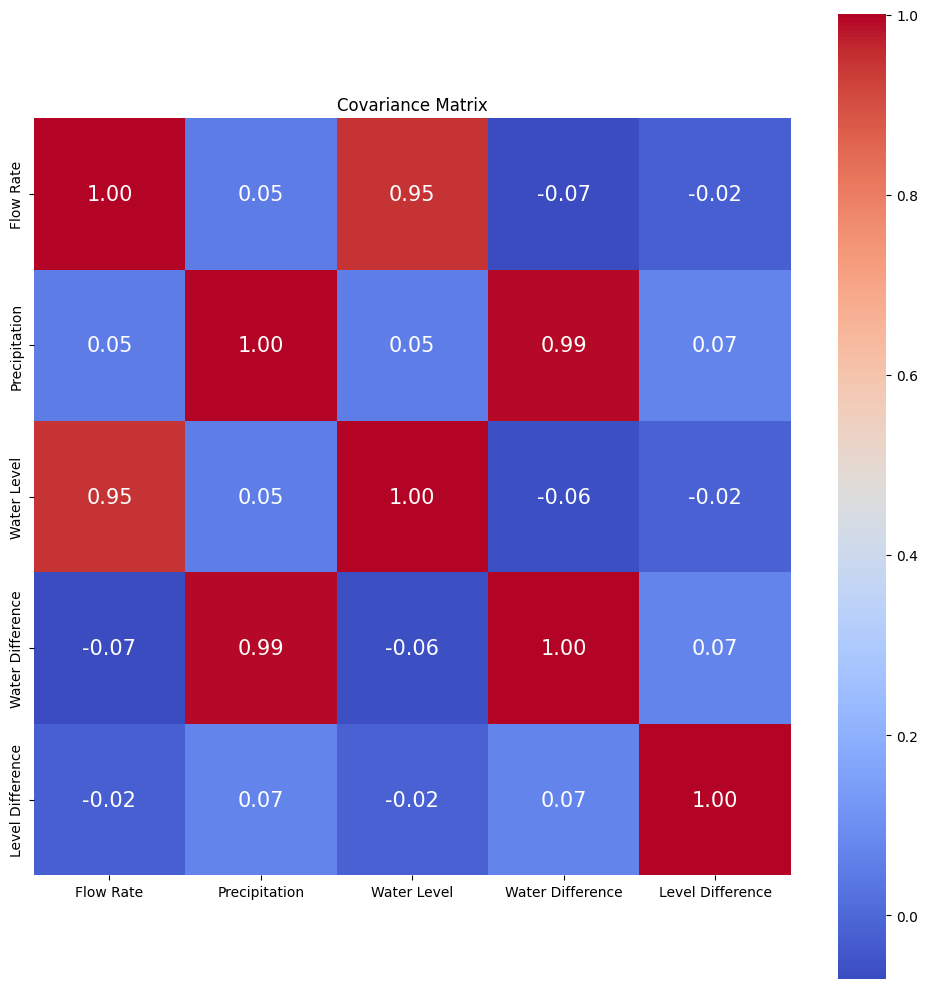

In [11]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(merged[cols].values)
cov_mat = np.cov(X_std.T)
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cov_mat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm', yticklabels=cols, xticklabels=cols)
plt.title('Covariance Matrix')
plt.tight_layout()
plt.show()

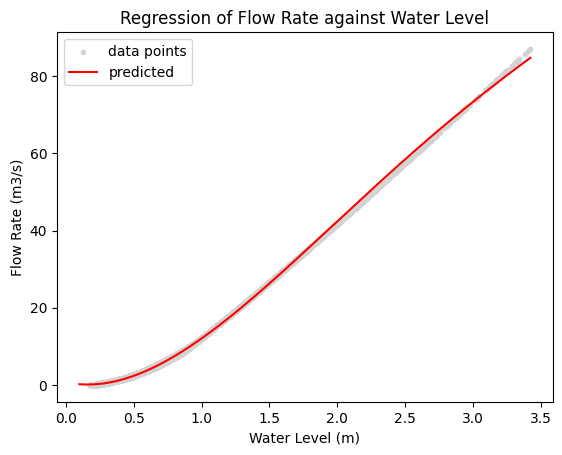

In [12]:
# Fit a polynomial curve to the data
X = merged['Water Level'].values.reshape(-1, 1)
y = merged['Flow Rate'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
quadratic = PolynomialFeatures(degree=4)
X_quad = quadratic.fit_transform(X)
X_quad_test = quadratic.fit_transform(X_test)
lr = LinearRegression()
lr.fit(X_quad, y)
y_quad_fit = lr.predict(X_quad)
y_quad_pred = lr.predict(X_quad_test)

# Plot the polynomial curve
plt.scatter(X, y, label='data points', color='lightgray', marker='.')

x = np.linspace(0.1, max(X), 1000)
y = lr.predict(quadratic.fit_transform(x.reshape(-1, 1)))
plt.plot(x, y, label='predicted', color='red')

plt.legend(loc='upper left')
plt.title('Regression of Flow Rate against Water Level')
plt.xlabel('Water Level (m)')
plt.ylabel('Flow Rate (m3/s)')
plt.show()